# Using pandas
[pandas](https://pandas.pydata.org/) is a **very** useful Python library to manipulate data. If you plan to pursue data science, it is worth learning this library as it is very frequently used. Feel free to use pandas for your assignment; you can also do the assignment without it if you wish.

Some useful links for pandas are:
* [w3schools tutorial](https://www.w3schools.com/python/pandas/default.asp)
* [pandas summary](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

In [15]:
from typing import NamedTuple, List
import csv
import pandas as pd

# Philosophy
There may be times when you have lots of data in CSV form (e.g., from a survey you have run) ) and you need to insert that data into a database. Due to the volume of responses, it is not feasible to do this manually.

Thus, you may want to write some code so that you can read in a file and programatically generate the required `INSERT` statements. We also want to do a bit of data cleaning to filter out bad data.

# Domain
Consider the following diagram

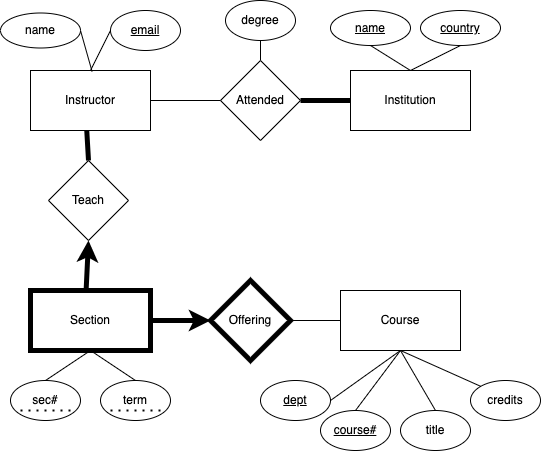

**We are only going to focus on the Instructor and Institution entity sets for this assignment.**

In your database, assume you have created the `Instructor`, `Institution`, and `Attended` tables with the following statements:

```
CREATE TABLE Instructor (email VARCHAR(255) PRIMARY KEY, name VARCHAR(255) NOT NULL) 

CREATE TABLE Instituition (name VARCHAR(255), country VARCHAR(255), PRIMARY KEY(name, country)) 

CREATE TABLE Attended (email VARCHAR(255), school_name VARCHAR(255), country VARCHAR(255), degree VARCHAR(9), PRIMARY KEY(email, school_name, country), FOREIGN KEY(email) REFERENCES Instructor ON DELETE CASCADE, FOREIGN KEY(school_name, country) REFERENCES Institution)
```

# Step 1: Consider the data
Take a look at the `instructor_data.csv` file. In it, you will find a CSV file with columns similar to the one you generated earlier. That is, you will find a CSV with the following format:

| Email | Name | Degree | InstitutionName | InstitutionCountry |
|-|-|-|-|-|
| jing@ubc.ca | Jing Amari | PhD | UNICAMP Universidade Estadual de Campinas | Brazil |

This file is slightly different from the one you generated in part one of the assignment because it includes information about all the degrees an instructor has ever earned. That is, if Jing has earned a BA, MA, and then a PhD, you would see three rows that have the same email address value.

**Data duplication is risky because it increases the chances of unclean data.** For example, what happens if two rows have the same email address but different names? Has Jing changed their name or is it a data entry error?

1. How should we handle cases where email values are the same but the names do not match? Provide at least one reason for your answer.
2. How should we handle cases where the `InstitutionCountry` does not contain an institution with `InstitutionName`? Provide at least one reason for your answer.

When answering the two questions above, be sure to consider the restrictions imposed on the data by the given SQL DDL statements.

Solution:
1. For cases where emails values are same, but names do not match, we should delete some entries and only keep one, since we purposedly specified `email` to be the primary key, hence it should be unique. Moreover, we let `name` to be not null, so it must exists, hence it likely a name is entered by error or the person change its name (with low chances).  **CHECK THIS**
2. For cases where `InstitutionCountry` that does not contain an institution with `InstitutionName`, we could ignore these scenarios, since we specified that the `InstitutionCountry` + `InstitutionName` combo is a primary key itself, so incomplete rows could be discard instead.

# Step 2: Creating a data processing plan
This CSV file actually contains information that we can use to populate all of the `Instructor`, `Instituition`, and `Attended` tables. The data is all over the place so we need to first read in the file and store the data in a way that is useful to us. Take a moment now to consider where the data for each of the tables exists in the file.

You are not allowed to make any assumptions about the data unless told otherwise by the question.

In [16]:
# read the csv using pandas
data_path = "data/instructor_data.csv"
df = pd.read_csv(data_path, on_bad_lines="warn")
df.head()

Skipping line 22: expected 5 fields, saw 6
Skipping line 28: expected 5 fields, saw 6
Skipping line 32: expected 5 fields, saw 6
Skipping line 40: expected 5 fields, saw 6
Skipping line 42: expected 5 fields, saw 6
Skipping line 51: expected 5 fields, saw 6
Skipping line 67: expected 5 fields, saw 6
Skipping line 88: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6
Skipping line 114: expected 5 fields, saw 6
Skipping line 130: expected 5 fields, saw 6
Skipping line 139: expected 5 fields, saw 6
Skipping line 147: expected 5 fields, saw 6
Skipping line 159: expected 5 fields, saw 6
Skipping line 175: expected 5 fields, saw 6
Skipping line 194: expected 5 fields, saw 6
Skipping line 198: expected 5 fields, saw 6
Skipping line 207: expected 5 fields, saw 6
Skipping line 250: expected 5 fields, saw 6
Skipping line 255: expected 5 fields, saw 6
Skipping line 259: expected 5 fields, saw 6
Skipping line 272: expected 5 fields, saw 6
Skipping line 278: expected 5 fields, saw

,Email,Name,Degree,Institution Name,Institution Country
0,danielleburgess@gmail.com,Danielle Burgess,Bachelors,University of Greenland,Greenland
1,danielleburgess@gmail.com,Danielle Burgess,Masters,Royal University of Bhutan,Bhutan
2,deannaharris@example.net,Deanna Harris,Bachelors,Khulna University of Engineering And Technology,Bangladesh
3,deannaharris@example.net,Deanna Harris,Masters,European University Portugal,Portugal
4,josephandrews@hotmail.com,Joseph Andrews,Bachelors,University of Swaziland,Swaziland


## Step 2a: Gathering `Institution` data
To simplify things for this assignment, you are allowed to assume that the `InstitutionName` and `InstitutionCountry` values will always be consistent with each other. That is, a given `InstitutionName` will be an existing institution within `InstitutionCountry`.

Where can you find data for the `Institution` table?

We could find it in the `Institution Name` and `Institution Country` columns of the `instructors.csv` file, which should be the 4th and 5th column of that `csv` file in that order.

## Step 2b: Gathering `Instructor` data
Data for the Instructor table is tricky as data about someone can be in non-sequential rows and you have to consider how you want to handle situations where there is data inconsistency. For example:

| Email | Name | Degree | InstitutionName | InstitutionCountry |
|-|-|-|-|-|
| jing@ubc.ca | Jing Amari | PhD | UNICAMP Universidade Estadual de Campinas | Brazil |
| jing@ubc.ca | J Amari | Bachelors | University of British Columbia | Canada |
| jbell@ubc.ca | Jingle Bell | Masters | University of British Columbia | Canada |
| jing@ubc.ca | Amari Jing | Masters | University of Tokyo | Japan |
| jbell@ubc.ca | Jingle Bells | Bachelors | University of British Columbia | Canada |

A human would be able to look at the first, second, and fourth rows of this data file and see that the data likely refers to the same person. However, a computer is not nearly as smart and there can be life events which cause someone to change their name. From the data that we have, it is hard to tell whether the differences are intentional.

For this assignment, we will assume that the name used in the terminal degree is the correct name. By terminal degree, we mean the last degree that someone has completed. In the example above, we will assume that the correct name associated with jing@ubc.ca is Jing Amari and the correct name associated with jbell@ubc.ca is Jingle Bell. 

(**Disclaimer**: we aren't saying that this is a good data cleaning policy - it is just the one we will use for this assignment.)

Where can you find data for the `Instructor` table?

We could find it in the `Email` and `Name` columns of the `instructors.csv` file, which should be the 1st and 2nd column of that `csv` file in that order.

## Step 2c: Gathering `Attended` data
Where can you find data for the `Attended` table?

We could find it in the `Email`, `Degree`,`Institution Name` and `Institution Country` columns of the `instructors.csv` file, which should be the 1st, 3rd, 4th, and 5th column of that `csv` file in that order.

# Step 3: Read in the CSV and produce the INSERT Statements

You have been given a file called `instructor_data.csv`. This file contains rows of instructor data that we have to convert to INSERT statements for our `Instructor`, `Institution` and `Attended` tables.

Write a function that accepts the name of the input data CSV file and the name of the ouput .sql file (i.e., the file that contains all of the INSERT statements). The function should convert the data in the input data CSV file to INSERT statements required for the three tables above. The INSERT statements should be written to a file with the given filename.

**Pay close attention to the order in which the INSERT statements must be placed in the file.**

In [117]:
# TODO: Put your solution to step 3 here
data_path = "data/instructor_data.csv"
def insert_sql(input_csv, output_sql):
    """
    Convert data in the input data CSV file to INSERT statements required into `output_sql` as filename
    """
    data = pd.read_csv(path=input_csv, on_bad_lines="warn")
    out = "insert_statements.sql"
    
    # Retrieve values from the data read of csv file
    EMAIL, NAME, DEGREE, COUNTRY, INSTITUTION = [data[col] for col in data.columns ]
    
    # Creates dict that maps the data required for specific table (key name of the dict here)
    mapper = {"Instructor": {"email":EMAIL,
                         "name":NAME
                        },
          "Institution": {"name":NAME,
                          "country":COUNTRY
                         },
          "Attended": {"email":EMAIL,
                       "school_name":INSTITUTION,
                       "country": COUNTRY,
                       "degree": DEGREE    
                      }
        }
    #tables = ["Instructor", "Institution", "Attended"]
    with open(out, "w") as f:
        for table in mapper:
            statement = "\nINSERT INTO "
            values = "\nVALUES "
            f.write(statement + table)
            # converting the values to one string separated by comma
            for attributes in mapper[table].values():
                content = ','.join(f'"{val}"' for val in attributes)
                f.write(values + "(" + content +")")


In [3]:
# TODO: call the function to test it


## Warning!
Taking values from a CSV (or a user) and inputting it directly into your database can be **extremely** dangerous. We will look into this further in a future assignment.<br />

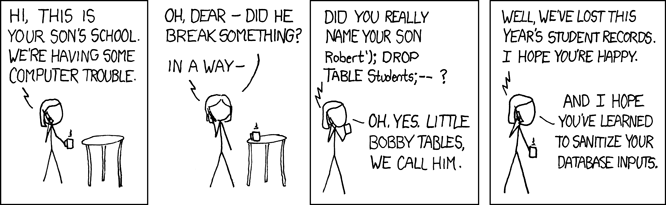
*https://xkcd.com/327/*

# Submitting Your Work
Once you are finished with the assignment, download the file by going to File -> Download As -> Notebook (.ipynb). This will allow you to save the file to a local location on your computer. 

Upload the Jupyter file **and** your .sql file to Canvas.